Prepare a dataset from which you can load image patches of cranberries with a descriptor for each patch. This only needs to be run once, unless you change anything in the dataset.
Produces a file that 

### 1. Prepare the dataframe that describes all the images in the dataset. Decide parameters (image scaling, patch size).

In [ ]:
# from ipynb.fs.full.data_prep import get_bog_2_df
from data_prep import get_tlc_df

tlc_df = get_tlc_df()
print(list(tlc_df))
print(f'{tlc_df.shape = }')

['filename', 'rel_path', 'plot', 'date', 'fungicide', 'file_type']
bog_2_df.shape = (830, 6)


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.ndimage import gaussian_filter
from patchify import patchify, unpatchify
import utils
from tqdm import tqdm
import cv2
import zarr

PATCH_SIZE = 224
S = 3 # scaling factor for what you want to resize original images to
OG_IMG_RESCALE = (2*PATCH_SIZE*S, 3*PATCH_SIZE*S) # maintain the 2:3(width:height) aspect ratio and multiple of patch size. NOTE - this is h,w but cv2 takes w, h

config = utils.load_toml('./dataset_locations.toml')
tlc_root = config['tlc_root']

### 2. Define function that takes an image, splits it into patches, and filters out patches that have PVC pipe.

In [ ]:
def pvc_check(patches: np.ndarray):
    '''
    Take in batch of patches, and return a bool array to indicate which patches have PVC pipe in them
    '''
    hsv_patches = colors.rgb_to_hsv(patches)
    saturation = gaussian_filter(hsv_patches[..., 1], sigma=7)
    value = gaussian_filter(hsv_patches[..., 2], sigma=7)
    # hue = gaussian_filter(hsv_patches[..., 0], sigma=7)

    # a few different conditions that work better or worse depending on the picture
    return gaussian_filter(((saturation < 0.3) & (value > 0.4)).astype(np.float32), sigma=7) > 0.4
    # return saturation < 0.2
    # return value > 0.8

def image_to_patches(image: np.ndarray, debug=True):
    '''
    Take in an image and return a list of image patches that exclude
    those which contain PVC pipe

    Args:
        image (ndarray): [H, W, 3] image
        debug (bool): If true, display the original image and patch mask

    Returns:
        Tuple containing an array of valid patches and an array of invalid patches
    '''

    pvc_mask = pvc_check(image)

    img_patches = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
    mask_patches = patchify(pvc_mask, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE)
    mask_patches = np.mean(mask_patches, axis=(-1, -2))
    mask_patches = mask_patches > 0.02

    if debug:
        plt.figure(figsize=(9,6))
        image_copy = np.copy(image)
        image_copy[:, ::PATCH_SIZE, :] = [0,0,0]
        image_copy[::PATCH_SIZE, :, :] = [0,0,0]
        plt.imshow(image_copy)

        rgba = np.zeros((*mask_patches.shape, 4))
        rgba[mask_patches] = [1,0,0,1]

        plt.imshow(rgba, alpha=0.5, extent=[0, OG_IMG_RESCALE[1], OG_IMG_RESCALE[0], 0])
        plt.tight_layout()
        plt.title("Sample image")
        plt.show()

    return np.squeeze(img_patches[~mask_patches]), ~mask_patches

Original image size: (5792, 8688, 3)
Resized image size: (1344, 2016, 3)


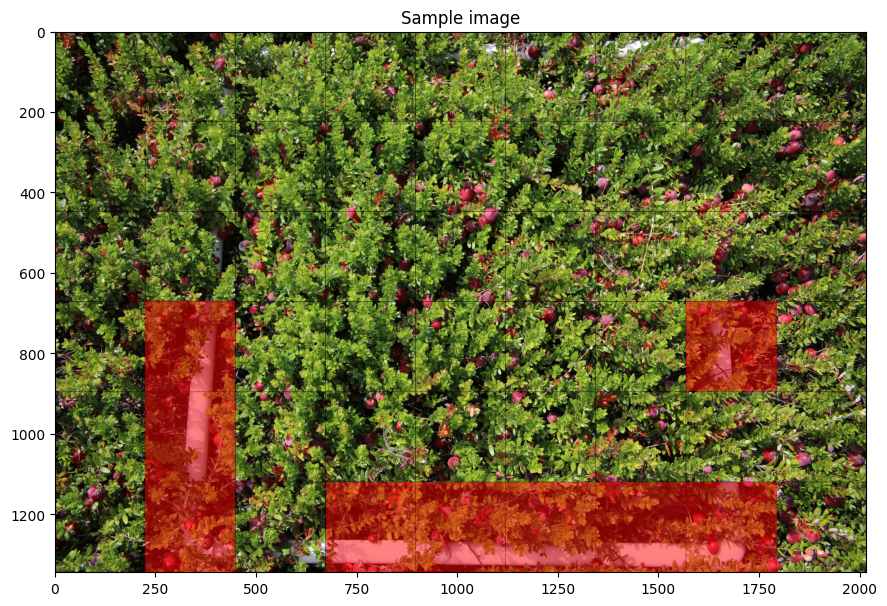

patches.shape=(45, 224, 224, 3)
mask.shape=(6, 9)


In [ ]:
test_img = cv2.cvtColor(cv2.imread(tlc_root + "/" + tlc_df.iloc[0].rel_path), cv2.COLOR_BGR2RGB) / 255.0
print(f'Original image size: {test_img.shape}')
test_img = cv2.resize(test_img, OG_IMG_RESCALE[::-1], interpolation=cv2.INTER_LINEAR)
print(f'Resized image size: {test_img.shape}')
patches, mask = image_to_patches(test_img, debug=True);

w, h = PATCH_SIZE, PATCH_SIZE
bad_patch_indices = np.array(np.nonzero(~mask))
xy = bad_patch_indices * PATCH_SIZE

xyhw = np.zeros((xy.shape[0] + 2, xy.shape[1]))
xyhw[:2] = xy
xyhw[2] = h
xyhw[3] = w

print(f'{patches.shape=}')
print(f'{mask.shape=}')

### 3. Organize all patch information into a pandas dataframe and save it to disk. Save all resized images to disk in the form of a `zarr` array.

In [5]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def timing(label=""):
    start = perf_counter()
    yield
    end = perf_counter()
    print(f"{label} took {end - start:.6f} seconds")

In [ ]:
tlc_jpegs = tlc_df[tlc_df.file_type == 'jpg']
tlc_patches_df = pd.DataFrame(columns=['plot', 'date', 'fungicide', 'patch_coords'])

w, h = PATCH_SIZE, PATCH_SIZE

max_patch_per_image = 2*S * 3*S
max_num_patches = len(tlc_jpegs.index) * max_patch_per_image
zarr_file_path = f"./prepped_data/tlc_patches_p{PATCH_SIZE}_size_{OG_IMG_RESCALE[0]}x{OG_IMG_RESCALE[1]}.zarr"

# create array to fit the maximum possible number of patches
z = zarr.create_array(
    store=zarr_file_path,
    shape=(max_num_patches, PATCH_SIZE, PATCH_SIZE, 3),
    chunks=(1, PATCH_SIZE, PATCH_SIZE, 3),
    dtype="f4"
)

# counter = 0
z_idx = 0
for index, row in tqdm(list(tlc_jpegs.iterrows())):
    im = cv2.cvtColor(cv2.imread(tlc_root + "/" + row['rel_path']), cv2.COLOR_BGR2RGB) / 255.0
    im = cv2.resize(im, OG_IMG_RESCALE[::-1], interpolation=cv2.INTER_LINEAR)
    
    patches, mask = image_to_patches(im, debug=False)
    patch_coords = np.array(np.nonzero(mask)).T
    num_patches = patches.shape[0]

    z[z_idx:z_idx+num_patches, ...] = patches
    
    new_rows = pd.DataFrame({
        "plot": row['plot'],
        "date": row['date'],
        "fungicide": row['fungicide'],
    }, index=np.arange(z_idx, z_idx+num_patches))
    new_rows['patch_coords'] = list(patch_coords)

    tlc_patches_df = pd.concat([tlc_patches_df, new_rows])
    
    z_idx += num_patches


# shrink array to fit the actual number of patches
z.resize((z_idx, PATCH_SIZE, PATCH_SIZE, 3))

tlc_patches_df._metadata = ['dataset_info']
tlc_patches_df.dataset_info = {
    "OG_IMG_RESCALE": OG_IMG_RESCALE,
    "PATCH_SIZE": PATCH_SIZE,
    "GRID_DIMS": (2*S,3*S),
    "dataset_name": "bog_2_daily_photos",
    "zarr_file_path": zarr_file_path
}

torch.save(tlc_patches_df, zarr_file_path.replace('zarr', 'pt'))

  0%|          | 0/830 [00:00<?, ?it/s]

100%|██████████| 830/830 [20:22<00:00,  1.47s/it]
